In [98]:
import torch
from torchvision import transforms, datasets
from torchvision.models import resnet
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
from matplotlib import pyplot as plt

In [99]:
do_transform = False
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
if do_transform:
    # Download CIFAR-10 dataset
    cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
else:
     cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [100]:
# Load CIFAR-10 data into a NumPy array
# print(cifar_dataset.shape)
images_array = []
labels_array = []

for i in range(len(cifar_dataset)):
    image, label = cifar_dataset[i]
    images_array.append(image)
    labels_array.append(label)

# Convert the tuple of NumPy arrays to NumPy arrays
images_array = np.array(images_array)
labels_array = np.array(labels_array)

# Print the shape of the NumPy arrays
print("Images array shape:", images_array.shape)
print("Labels array shape:", labels_array.shape)

Images array shape: (50000, 32, 32, 3)
Labels array shape: (50000,)


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming images_array and other variables are defined

images = images_array[:100]
flat_images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2], images.shape[3]))
N, size, D = flat_images.shape

num_clusters = [5, 10, 20]
output_images = np.zeros((len(num_clusters), N, size, D))

for k in range(len(num_clusters)):
    for i in range(N):
        n = num_clusters[k]
        kmeans = KMeans(n_clusters=n, n_init="auto").fit(flat_images[i])
        assignments = kmeans.labels_.reshape((size, 1))  # Reshape to broadcast cluster assignments
        cluster_centers = kmeans.cluster_centers_
        
        # Use assignments as indices to select the cluster centers
        output_images[k][i] = cluster_centers[assignments.flatten()]



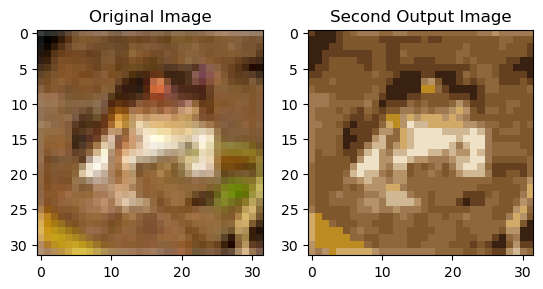

In [103]:

# Assuming you want to plot the second output image
second_output_image = output_images[1]

# Choose an index for the image you want to visualize
image_index = 0

# Display the original and second output image
plt.subplot(1, 2, 1)
plt.imshow(images[image_index].astype(np.uint8).reshape((32,32,3)))  # Ensure the original image is uint8
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(second_output_image[image_index].reshape(images.shape[1], images.shape[2], images.shape[3]).astype(np.uint8).reshape((32,32,3)))
plt.title('Second Output Image')

plt.show()

In [105]:
def apply_transform(images):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
    return np.array([transform(img) for img in images])

images_to_train = apply_transform(images_array)
compressed_images = apply_transform(output_images)

In [106]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from itertools import islice
from resnet import resnet50  # Assuming you have the resnet module

# Load CIFAR-10 data into a NumPy array (images_array and labels_array)
# ... (the code you provided)

# Convert the NumPy arrays to PyTorch tensors
output_images_reshaped = compressed_images[1, :, :, :]

output_images_reshaped = np.reshape(output_images_reshaped, (100, 32, 32, 3))

images_tensor = torch.tensor(images_to_train[:100])
labels_tensor = torch.tensor(labels_array[:100])

# Convert output_images to PyTorch tensor
output_tensor = torch.tensor(output_images_reshaped)

# images_tensor = images_tensor.permute(0, 3, 1, 2)
output_tensor = output_tensor.permute(0, 3, 1, 2)



In [107]:
print(output_tensor.shape)
print(labels_tensor.shape)
print(images_tensor.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100])
torch.Size([100, 3, 32, 32])


In [108]:
# Create separate DataLoaders for each dataset
images_dataset = TensorDataset(images_tensor, labels_tensor)
output_dataset = TensorDataset(output_tensor, labels_tensor)

images_dataloader = islice(DataLoader(images_dataset, batch_size=1, shuffle=True), 1000)
output_dataloader = islice(DataLoader(output_dataset, batch_size=1, shuffle=True), 1000)

In [109]:


# Set random seed for reproducibility
torch.manual_seed(42)

# Load the pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Define the transformation to be applied to your input image


# Loop through the images from images_dataloader and make predictions
correct_predictions_images = 0
for image, label in tqdm(images_dataloader, total=1000):
    image = image.float()
    with torch.no_grad():
        output_image = model(image)
    
    _, predicted_class_images = output_image.max(1)
    # Check if the predictions are correct
    correct_predictions_images += (predicted_class_images == label).item()

# Loop through the output_images and make predictions
correct_predictions_output = 0
for output, label in tqdm(output_dataloader, total=1000):
    output = output.float()
    with torch.no_grad():
        out_image = model(output)
    
    _, predicted_class_output = out_image.max(1)

    # Check if the predictions are correct
    correct_predictions_output += (predicted_class_output == label).item()

# Print the total number of correct predictions
print(f"Total correct predictions for images: {correct_predictions_images}")
print(f"Total correct predictions for compressed images: {correct_predictions_output}")


 10%|█         | 100/1000 [00:03<00:29, 30.51it/s]

Total correct predictions for images: 100
Total correct predictions for compressed images: 6
